In [1]:
import numpy as np
import fdringdown as rd
import astropy.constants as const

import matplotlib.pyplot as plt
import rcparams
plt.rcParams.update(rcparams.params)
plt.rcParams.update({'font.size': 12})

import pykerr

from matplotlib.lines import Line2D
from scipy.special import erf, erfcx

In [2]:
G, c, M_sun, au = const.G.value, const.c.value, const.M_sun.value, const.au.value

# G/c**3 (s/kg)
conversion = G/c**3

# Livingston interferometer
L = rd.interferometer('L1')

In [3]:
def fd_ringdown(freqs, start_time, amplitudes, frequencies):
    
    # To calculate the plus and cross polarizations, we need to evaluate the
    # frequency-domain model at postive and negative frequencies. Create a new
    # freqs array where the second half of the array contains negative 
    # frequencies.
    all_freqs = np.hstack((freqs, -freqs))
    
    # Create an empty array to add the result to
    h = np.zeros(len(freqs), dtype=complex)
    
    # Dictionary to store the plus and cross polarizations
    h_dict = {'plus':h.copy(), 'cross':h.copy()}
    
    # Construct the ringdown sum
    for C, omega in zip(amplitudes, frequencies):
        
        numerator = C*np.exp(-2*np.pi*(1j)*all_freqs*start_time)
        denominator = 2*np.pi*(1j)*all_freqs + (1j*omega)
        
        # The Fourier tranform of the complex ringdown
        h_all_freqs = numerator/denominator
        
        # Split into positive and negative frequency waveforms
        h_positive, h_negative = np.split(h_all_freqs, [len(freqs)])
        
        # Calculate the plus and cross components and store to dictionary
        h_dict['plus'] += (h_positive + np.conj(h_negative))/2
        h_dict['cross'] += -(h_positive - np.conj(h_negative))/2j
    
    return h_dict

def fd_truncated_wavelet(freqs, central_times, amplitudes, frequencies, 
                         damping_times, start_time):
    
    # To calculate the plus and cross polarizations, we need to evaluate the
    # frequency-domain model at postive and negative frequencies. Create a new
    # freqs array where the second half of the array contains negative 
    # frequencies.
    all_freqs = np.hstack((freqs, -freqs))
    
    # Create an empty array to add the result to
    h = np.zeros(len(freqs), dtype=complex)
    
    # Dictionary to store the plus and cross polarizations
    h_dict = {'plus':h.copy(), 'cross':h.copy()}
    
    # Construct the wavelet sum
    for tc, C, f, tau in zip(
        central_times, amplitudes, frequencies, damping_times
        ):
        
        # Calculate the Fourier transform
        h_all_freqs = 0.5*np.sqrt(np.pi)*tau*C*np.exp(-2*np.pi*1j*all_freqs*tc)
        
        # To deal with the error function, we group it with the 
        # exp(-pi**2*(f+f0)**2*tau**2) which helps supress (some of) the 
        # numerical errors. When we do this, we can use the SciPy erfcx
        # function. 
        
        # Real part of the error function argument
        a = (start_time - tc)/tau
        
        # Imaginary part of the error function argument
        b = np.pi*(f+all_freqs)*tau
        
        z = a + 1j*b
        
        h_all_freqs *= (2*np.exp(z**2) - erfcx(z))
        h_all_freqs *= np.exp(a*(a-2*z))
        
        # Split into positive and negative frequency waveforms
        h_positive, h_negative = np.split(h_all_freqs, [len(freqs)])
        
        # Calculate the plus and cross components and store to dictionary
        h_dict['plus'] += (h_positive + np.conj(h_negative))/2
        h_dict['cross'] += -(h_positive - np.conj(h_negative))/2j
    
    return h_dict

In [4]:
# GW190521_mock/1W220/46
medians_fixed = {
    'eta': 3.98664438e-02,
    'A_w': 2.00767511e-21,
    'phi_w': 3.34670585e+00,
    'nu': 4.03128176e+01,
    'tau': 4.04633557e-02,
    
    'A_rd': 7.80096466e-22,
    'phi_rd': 3.62173403e+00,
    't0': 1.17412549e-02,
    'Mf': 2.59610252e+02,
    'chif': 6.76786993e-01,
    
    'ra': 1.64000000e-01,
    'dec': -1.14000000e+00,
    't_event': 1.24244297e+09,
    'psi': 2.38000000e+00,
    }

maxl_fixed = {
    'eta_0': 1.63738637e-02,
    'Ap_w_0': 1.20439458e-21,
    'Am_w_0': 0,
    'phip_w_0': 2.14241474e+00,
    'phim_w_0': 0,
    'nu_0': 3.99639698e+01,
    'tau_0': 3.09685814e-02,
    
    't_0': 1.17412549e-02,
    'A_rd_0': 7.51438758e-22,
    'phi_rd_0': 3.67124347e+00,
    'M_f': 2.69683326e+02,
    'chi_f': 7.25249277e-01,
    
    'iota': 0,
    'varphi': 0,
    'ra': 1.64000000e-01,
    'dec': -1.14000000e+00,
    't_event': 1242442967.4,
    'psi': 2.38000000e+00
    }


# GW190521_mock/1W220/43

maxl_sky = {
    'eta_0': 0.002084955426888545,
    'Ap_w_0': 1.1572020901758727e-21,
    'Am_w_0': 0,
    'phip_w_0': 3.1643688723356656,
    'phim_w_0': 0,
    'nu_0': 32.44143614926651,
    'tau_0': 0.019801520477767117,
    
    't_0': 0.010568980291093606,
    'A_rd_0': 8.459382929180023e-22,
    'phi_rd_0': 1.1410645973431097,
    'M_f': 258.790588572115,
    'chi_f': 0.6592846998591365,
    
    'iota': 0,
    'varphi': 0,
    'ra': 0.0871276025385507,
    'dec': -1.172283910066476,
    't_event': 1242442967.4,
    'psi': 1.0095878583465292
    }

medians_sky = {
    'eta': 3.71149318e-02,  
    'A_w': 1.75104157e-21,  
    'phi_w': 3.17089068e+00,  
    'nu': 3.93369729e+01,
    'tau': 4.12654605e-02,  
    
    'A_rd': 7.99991797e-22,  
    'phi_rd': 3.68776728e+00,  
    't0': 1.09606208e-02,
    'Mf': 2.61339880e+02,  
    'chif': 6.75424706e-01,  
    
    'ra': 1.84684838e-01,
    'dec': -1.14795877e+00,  
    't_event': 1.24244297e+09,  
    'psi': 1.36990953e+00
    }

params = maxl_sky

omega = pykerr.qnm.qnmomega(params['chi_f'], 2, 2, 0)/(params['M_f']*M_sun*conversion)

In [5]:
times = np.linspace(-1, 1, num=5000)

td_model = rd.wavelet_ringdown_sum([(2,2,0)], 1)
td_wf = td_model.waveform(times, {**params, **{'A_rd_0': params['A_rd_0']/pykerr.spheroidal(0, params['chi_f'], 2, 2, 0)}})
td_signal = L.project(td_wf, params['ra'], params['dec'], params['t_event'], params['psi'])

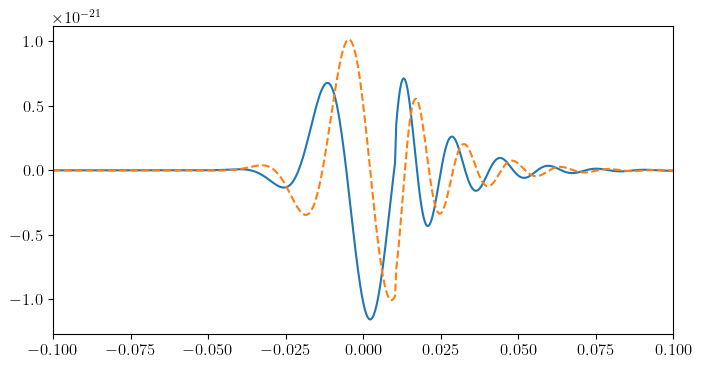

In [6]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(times, np.real(td_wf))
ax.plot(times, -np.imag(td_wf), '--')

_ = ax.set_xlim(-0.1, 0.1)

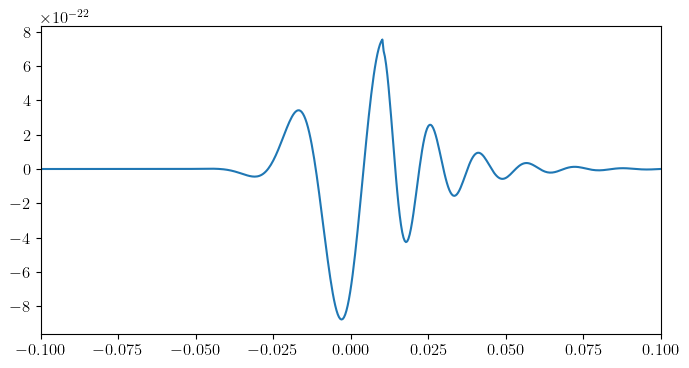

In [7]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(times, td_signal)

_ = ax.set_xlim(-0.1, 0.1)

In [8]:
td_w_wf = td_wf.copy()
td_rd_wf = td_wf.copy()

td_w_wf[times > params['t_0']] = 0
td_rd_wf[times < params['t_0']] = 0

td_w_signal = L.project(td_w_wf, params['ra'], params['dec'], params['t_event'], params['psi'])
td_rd_signal = L.project(td_rd_wf, params['ra'], params['dec'], params['t_event'], params['psi'])

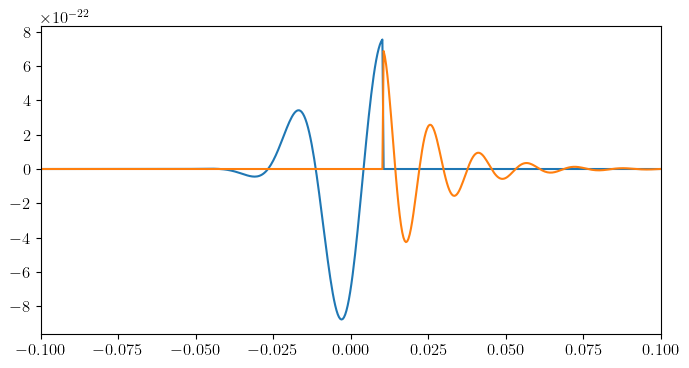

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(times, td_w_signal)
ax.plot(times, td_rd_signal)

_ = ax.set_xlim(-0.1, 0.1)

In [10]:
freqs = np.logspace(np.log10(0.1), np.log10(4000), num=1000)

rd_polarisations = fd_ringdown(
    freqs, 
    params['t_0'], 
    [params['A_rd_0']*np.exp(1j*(params['phi_rd_0']))], 
    [omega]
    )

w_polarisations = fd_truncated_wavelet(
    freqs, 
    [params['eta_0']], 
    [params['Ap_w_0']*np.exp(1j*params['phip_w_0'])], 
    [params['nu_0']], 
    [params['tau_0']], 
    params['t_0']
    )

sum_polarisations = {
    'plus': rd_polarisations['plus'] + w_polarisations['plus'],
    'cross': rd_polarisations['cross'] + w_polarisations['cross']
    }

In [11]:
rd_signal = L.project(
    rd_polarisations, 
    params['ra'], 
    params['dec'], 
    params['t_event'], 
    params['psi'], 
    FD=True
    )

w_signal = L.project(
    w_polarisations, 
    params['ra'], 
    params['dec'], 
    params['t_event'], 
    params['psi'], 
    FD=True
    )

sum_signal = L.project(
    sum_polarisations, 
    params['ra'], 
    params['dec'], 
    params['t_event'], 
    params['psi'], 
    FD=True
    )

# Convert to characteristic strain
rd_char = 2*freqs*abs(rd_signal)
w_char = 2*freqs*abs(w_signal)
sum_char = 2*freqs*abs(sum_signal)

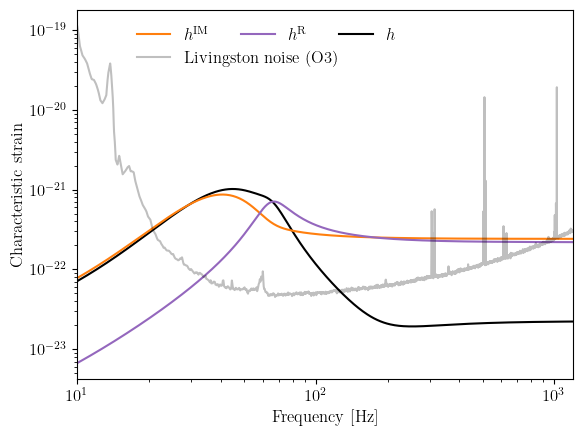

In [14]:
fig, ax = plt.subplots()

xlim = (10, 1200)

asd_freqs = np.logspace(np.log10(L.asd('O3').x[0]), np.log10(L.asd('O3').x[-1]), num=5000)
td_signal_fft_freqs = np.fft.rfftfreq(len(times), d=times[1]-times[0])

freqs_mask = (freqs > xlim[0]) & (freqs < xlim[-1])
asd_freqs_mask = (asd_freqs > xlim[0]) & (asd_freqs < xlim[1])
td_signal_fft_freqs_mask = (td_signal_fft_freqs > xlim[0]) & (td_signal_fft_freqs < xlim[1])

ax.plot(freqs[freqs_mask], np.abs(w_char)[freqs_mask], c='C1', label='$h^\mathrm{IM}$')
ax.plot(freqs[freqs_mask], np.abs(rd_char)[freqs_mask], c='C4', label='$h^\mathrm{R}$')

# td_w_signal_fft = np.fft.rfft(td_w_signal)*(times[1]-times[0])
# ax.plot(
#     td_signal_fft_freqs[td_signal_fft_freqs_mask], 
#     (2*td_signal_fft_freqs*np.abs(td_w_signal_fft))[td_signal_fft_freqs_mask], c='C1', ls='--'
#     )

# td_rd_signal_fft = np.fft.rfft(td_rd_signal)*(times[1]-times[0])
# ax.plot(
#     td_signal_fft_freqs[td_signal_fft_freqs_mask], 
#     (2*td_signal_fft_freqs*np.abs(td_rd_signal_fft))[td_signal_fft_freqs_mask], c='C4', ls='--'
#     )

ax.plot(freqs[freqs_mask], np.abs(sum_char)[freqs_mask], c='k', label='$h$', zorder=1)

# td_signal_fft = np.fft.rfft(td_signal)*(times[1]-times[0])
# ax.plot(
#     td_signal_fft_freqs[td_signal_fft_freqs_mask], 
#     (2*td_signal_fft_freqs*np.abs(td_signal_fft))[td_signal_fft_freqs_mask], c='k', ls='--'
#     )

ax.plot(
    asd_freqs[asd_freqs_mask], 
    np.sqrt(asd_freqs[asd_freqs_mask])*L.asd('O3')(asd_freqs[asd_freqs_mask]),
    c='k',
    alpha=0.25,
    # label='Livingston noise (O3)'
    )

l1 = ax.legend(
    loc='upper left',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.09,0.99)
    )
ax.add_artist(l1)

ax.legend(
    [Line2D([0],[0],c='k',alpha=0.25)],
    ['Livingston noise (O3)'],
    loc='upper left',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.09,0.93)
    )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(xlim)
# ax.set_ylim(ax.get_ylim()[0], 5e-20)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Characteristic strain')

fig.savefig('fd_median_wfs.pdf', bbox_inches='tight')